# Estimator lab exercise solution

When selecting a piece of chocolate candy from a box, the piece often meets our expectations. Sometimes after biting into the candy however, we find that the filling is not our favorite. This exercise leverages Qiskit Runtime and a Variational Quantum Eigensolver (VQE) to assemble a box of chocolates that hopefully meets our expectations. It uses the Qiskit Runtime Estimator to calculate the expectation values for combinations of candies in a box, and uses a Qiskit Runtime session to facilitate running a VQE algorithm to find the highest expectation value. This program draws upon code from an example that experimental physicist & IBM Quantum researcher Nick Bronn created for the [Coding with Qiskit Runtime video series](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqAC8DnVoLOzg2bKE4C7ARM), specifically in [Episode 05 Primitives & Sessions](https://youtu.be/yxuH8eb4MS4?si=e3trSORNjooWlQXu).

### 1. Install qiskit-algorithms

In [ ]:
!pip install qiskit-algorithms

### 2. Initialize the account

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

### 3. Create an operator

There are three pieces of chocolate candy in a box. Each piece can either have a vanilla center or a raspberry center. The user likes vanilla centers but dislikes raspberry centers, so we'll say that picking a vanilla it is worth 1 point, but picking a raspberry it is worth -1 point. To model this as an operator, we'll create three Pauli operators and sum them together. Each piece of candy in the box is represented by a qubit, and each of these Pauli's contain expectation values for their corresponding position in the box. Summing them together results in the diagonal of the operator containing eigenvalues that represent expectation values for all eight possible combinations of candy in the box. 

In [12]:
from qiskit.quantum_info import Operator, Pauli

# Create Pauli objects
pauli2 = Pauli('ZII')
pauli1 = Pauli('IZI')
pauli0 = Pauli('IIZ')

# Sum the matrices
choc_matrix = pauli2.to_matrix() + pauli1.to_matrix() + pauli0.to_matrix()

# Create a new Operator from the sum
choc_op = Operator(choc_matrix)

print(choc_op.to_matrix())


[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]


### 4. Setup and run a VQE algorithm

In [13]:
import numpy as np
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import Session, Estimator

#### a. Create a parameterized circuit to serve as the ansatz

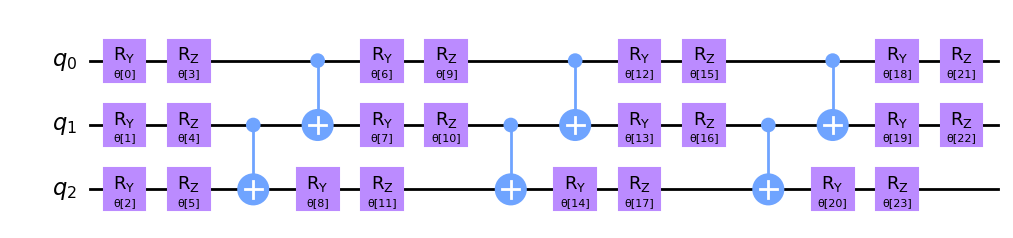

In [14]:
ansatz = EfficientSU2(3)
ansatz.decompose().draw('mpl')

#### b. Tweak some Qiskit Runtime options if desired

In [15]:
from qiskit_ibm_runtime import Options

options = Options()
options.resilience_level = 1
options.execution.shots = 1024

#### c. Implement VQE leveraging Session, Estimator and an optimizer

In [ ]:
with Session(backend=backend, max_time="1h"):
    estimator = Estimator(options=options)
    
    # Define a callback to print values in each iteration of the optimizer
    callback = lambda nfev, params, fval, step, acc: print(f'Evaluation {nfev}: {fval}')
    optimizer = SPSA(callback=callback, maxiter=800)

    # Define a cost function, flipping the sign so that the opimizer maximizes the expectation value
    cost_func = lambda params: estimator.run(ansatz, choc_op, parameter_values=params).result().values[0] * -1
    result = optimizer.minimize(cost_func, x0=np.zeros(ansatz.num_parameters))

#### d. Print and plot the results

In [17]:
print(result)

{   'fun': -2.98046875,
    'jac': None,
    'nfev': 2400,
    'nit': 800,
    'njev': None,
    'x': array([ -9.51558012,   4.69310965,   4.47706701,   6.79084069,
        -2.29130298, -11.75109692, -15.67317461, -11.35315873,
        -5.29278498,  -1.05031138, -11.18156733,  -7.02925484,
         6.25093223,  17.63902404,  11.06159565,  16.10125984,
        13.84511633,  10.7500245 , -12.42081527,  13.76667439,
        -8.53899216,  -1.76739589,  12.32214559, -29.14121114])}


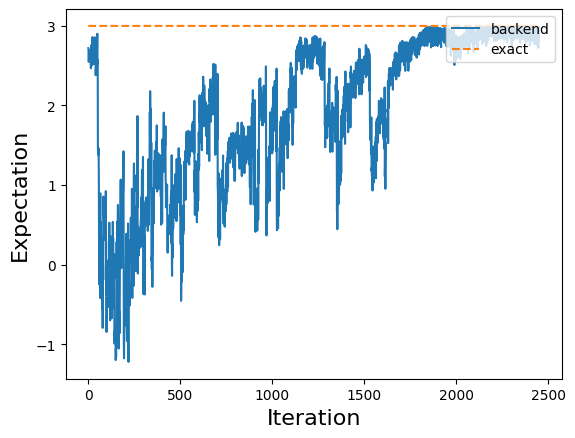

In [20]:
import matplotlib.pyplot as plt

# Replace <SESSION_ID> with the Session Id from the job.
jobs = service.jobs(session_id=<SESSION_ID>, limit=None)
expectations = [job.result().values[0] for job in jobs if job.done()][::-1]

plt.plot(range(len(expectations)), expectations, label='backend')
plt.plot(range(len(expectations)), [3.0]*len(expectations), ls='--', label='exact')
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Expectation', fontsize=16)
plt.legend(loc=1)